In [1]:
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_theme(style="darkgrid")

In [3]:
#Substituir o caminho abaixo pelo local onde está o seu arquivo fraud.csv
file_path = "fraud.csv"

df = pd.read_csv(file_path)

In [4]:
#Dimensões dos Dados:
print("DIMENSÕES DO DATAFRAME:")
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))

DIMENSÕES DO DATAFRAME:
Linhas:		6362620
Colunas:	11


In [5]:
df.isnull().sum().max()

0

#Análise Exploratória

Neste problema, estamos interessados em predizer se uma transação é fraudulenta ou não. Essa informação pode ser encontrada na coluna isFraud, coluna esta que chamarei de target!

Ao olharmos o target, percebemos que:

*   **0** : Transação normal;
*   **1** :Transação fraudulenta

Também concluímos que não existem informações sobre o balanço das transações para clientes que começam com a letra M, como mencionado na documentação do Dataset



In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Abaixo verificarei o resumo estatístico da base de dados, através do método describe().

Em relação aos valores transacionado (variável amount), nota-se que o valor médio de transações (considerando todas as categorias) é de 179.861, a mediana 74.871 e o desvio padrão de 603.858

Ao ver um desvio padrão tão alto, percebo que os dados de transação não estão distribuidos de forma muito homogênea (o que é péssimo para um algoritmo de machine learning). Precisarei tratar esse desbalanceamento mais tarde.

In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
df.amount.describe().apply("{0:.5f}".format)

count     6362620.00000
mean       179861.90355
std        603858.23146
min             0.00000
25%         13389.57000
50%         74871.94000
75%        208721.47750
max      92445516.64000
Name: amount, dtype: object

In [9]:
df.step.describe().apply("{0:.5f}".format)

count    6362620.00000
mean         243.39725
std          142.33197
min            1.00000
25%          156.00000
50%          239.00000
75%          335.00000
max          743.00000
Name: step, dtype: object

Também é possível perceber que não existem muitas categorias de valores ausentes nesta base de dados. Entretanto, o número de clientes destinatários que começam com a letra M é de 2.151.495 , o qual lidarei posteriormente

In [10]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
df.nameDest.str.startswith('M').sum()
#Contando o número de clientes destinatários que começam com a letra M

2151495

In [12]:
#Quantos % os clientes que começam com M representam do total?
print("Os clientes que começam com a letra M representam %.2f" % (df.nameDest.str.startswith('M').sum() / len(df.nameDest) * 100), "% do total de clientes." )

Os clientes que começam com a letra M representam 33.81 % do total de clientes.


Outro ponto que analisarei é: quantas transações fraudulentas existem, em porcentagem, nessa base de dados.

0    6354407
1       8213
Name: isFraud, dtype: int64

Fraudes representam 0.1291% do dataset.



[]

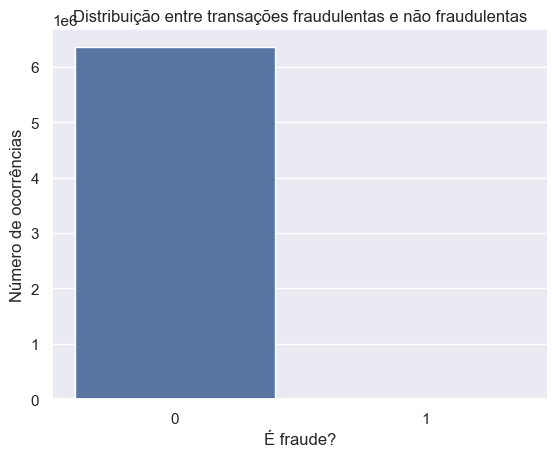

In [13]:
# ver o balanceamento das transações fraudulentas e não fraudulentas
print(df.isFraud.value_counts())
print("\nFraudes representam {:.4f}% do dataset.\n".format((df[df.isFraud == 1].shape[0] / df.shape[0]) * 100))

# plotar gráfico de barras para as transações
fig, ax = plt.subplots()
sns.countplot('isFraud', data=df, ax=ax)
ax.set_title('Distribuição entre transações fraudulentas e não fraudulentas')
ax.set_xlabel('É fraude?')
ax.set_ylabel('Número de ocorrências')
plt.plot()

Com o gráfico acima, percebi essa nítida discrepância. Na prática isso interferirá no desempenho do nosso modelo, e será necessário fazer um balanceamento dos dados antes de alimentar o modelo de classificação.

Seguindo minha análise exploratória, irei plotar o boxplot para ver se há diferença nos valores transacionados em fraudes e transações "normais".

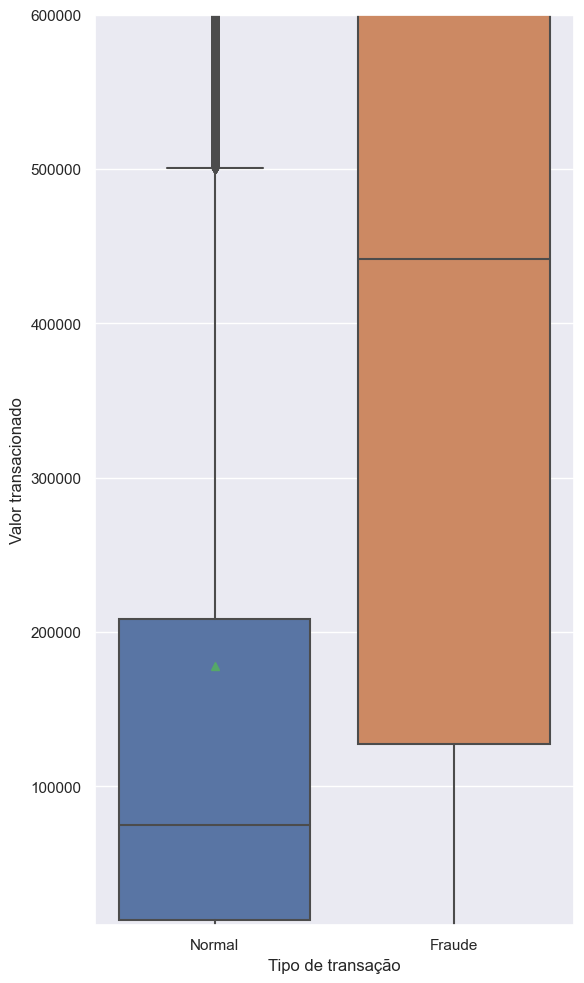

In [14]:
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(df.isFraud, df.amount, showmeans=True, ax=ax)
plt.ylim((10000, 600000))
plt.xticks([0, 1], ['Normal', 'Fraude'])

ax.set_xlabel('Tipo de transação')
ax.set_ylabel('Valor transacionado')

plt.tight_layout()

Informações estatísticas de transações fraudulentas podem ser observadas abaixo

In [15]:
df[(df.isFraud == 1) & (df.amount > 0)]['amount'].describe().apply("{0:.5f}".format)

#Informações estatísticas para transações fraudulentas cujo valor é > 0.
# A função apply é para formatarmos o dado do tipo float e melhorarmos a visualização

count        8197.00000
mean      1470832.67389
std       2405722.68353
min            63.80000
25%        127564.33000
50%        442290.23000
75%       1525742.02000
max      10000000.00000
Name: amount, dtype: object

De forma resumida, algumas informações principais que puderam ser extraídas dessa etapa exploratória foram:

 

*   O dataset está muito desbalanceado, uma vez que as transações fraudulentas representam apenas 0,129% das entradas totais.
*   As colunas Step e Amount não estão normalizadas.
*   33,81% dos clientes destinatários começam com a letra M (e possuem valores ausentes no balanço de suas transações).


#Preparando os dados

Para que possamos treinar nosso modelo de Regressão Logística, iremos:



*   Normalizar as *features* Step e Amount
*   Lidar com os dados ausentes dos clientes que começam com a letra M
*   Transformar a variável type em numérica
*   Dividir entre dados de treino e teste
*   Balancear os dados a fim de evitar uma baixa performance




###Normalizar Step e Amount

Uma vez que a coluna amount possui *outliers*, usarei a normalização por meio da classe StandardScaler

In [16]:
#Normalizar as colunas Time e Amount
df_clean = df.copy()

std_scaler = StandardScaler()

#Atribui os valores em uma nova escala
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['amount'].values.reshape(-1,1))
df_clean['std_step'] = std_scaler.fit_transform(df_clean['step'].values.reshape(-1,1))

df_clean.drop(['step', 'amount'], axis=1, inplace=True)

df_clean.head()

,type,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,std_amount,std_step
0,PAYMENT,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,-0.281560,-1.703042
1,PAYMENT,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-0.294767,-1.703042
2,TRANSFER,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,-0.297555,-1.703042
3,CASH_OUT,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,-0.297555,-1.703042
4,PAYMENT,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,-0.278532,-1.703042


###Transformar a variável Type em numérica (Label Encoder)



Irei transformar a variável categórica Type em uma variável numérica (que é o padrão usado em algoritmos de ML). Para isso usarei o LabelEncoder do sklearn.

In [17]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df_clean['Num_Type'] = le.fit_transform(df_clean['type'])

In [18]:
df_clean.drop(['type'], axis=1, inplace=True)

#Ver os dados novamente para saber se a coluna type foi devidamente removida
df_clean.head()

,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,std_amount,std_step,Num_Type
0,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,-0.281560,-1.703042,3
1,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-0.294767,-1.703042,3
2,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,-0.297555,-1.703042,4
3,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,-0.297555,-1.703042,1
4,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,-0.278532,-1.703042,3


###Preencher os dados ausentes em clientes que começam com M

Para essa etapa, irei substituir os valores oldbalanceDest e newbalanceDest dos clientes destinatários que começam com a letra M pela média.

Para isso, calculei a média das colunas e fiz a atribuição dos valores.

Podemos ver que o dataset foi de fato atualizado com o comando abaixo

In [19]:
meanOldBalanceDest = np.mean(df['oldbalanceDest'])
df_clean.loc[df_clean.nameDest.str.startswith('M'), 'oldbalanceDest'] = meanOldBalanceDest

meanNewBalanceDest = np.mean(df['newbalanceDest'])
df_clean.loc[df_clean.nameDest.str.startswith('M'), 'newbalanceDest'] = meanNewBalanceDest


In [20]:
df_clean.loc[df.nameDest.str.startswith('M'), 'newbalanceDest']

0          1.224996e+06
1          1.224996e+06
4          1.224996e+06
5          1.224996e+06
6          1.224996e+06
               ...     
6362312    1.224996e+06
6362314    1.224996e+06
6362316    1.224996e+06
6362318    1.224996e+06
6362319    1.224996e+06
Name: newbalanceDest, Length: 2151495, dtype: float64

Agora que tratamos os clientes que começam com a letra M, iremos eliminar as colunas que representam nomes, pois elas não serão significativas em nosso modelo.

In [21]:
df_clean.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

df_clean.head()

,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,std_amount,std_step,Num_Type
0,170136.0,160296.36,1.100702e+06,1.224996e+06,0,0,-0.281560,-1.703042,3
1,21249.0,19384.72,1.100702e+06,1.224996e+06,0,0,-0.294767,-1.703042,3
2,181.0,0.00,0.000000e+00,0.000000e+00,1,0,-0.297555,-1.703042,4
3,181.0,0.00,2.118200e+04,0.000000e+00,1,0,-0.297555,-1.703042,1
4,41554.0,29885.86,1.100702e+06,1.224996e+06,0,0,-0.278532,-1.703042,3


###Dividir entre conjunto de treino e teste

Antes de balancear os dados, irei splitar os dados já existentes em treino e teste. Caso contrário, não teríamos parâmetros para conferir se o balanceamento foi adequado.

Irei garantir que os conjuntos de treino e teste tenham a mesma quantidade de transações normais e transações fraudulentas proporcionalmente, através do comando stratify=y

In [22]:
X = df_clean.drop('isFraud', axis=1)
y = df['isFraud']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

###Balanceamento dos dados

Usarei a biblioteca *imblearn* para aplicar a técnica de balanceamento dos dados. Neste caso, usarei Under-sampling, preservando a classe minoritária.

Assim, fica fácil observar que não temos mais aquela discrepância inicial (gráfico de barras do início).

0    6160
1    6160
Name: isFraud, dtype: int64


Text(0, 0.5, 'Número de amostras')

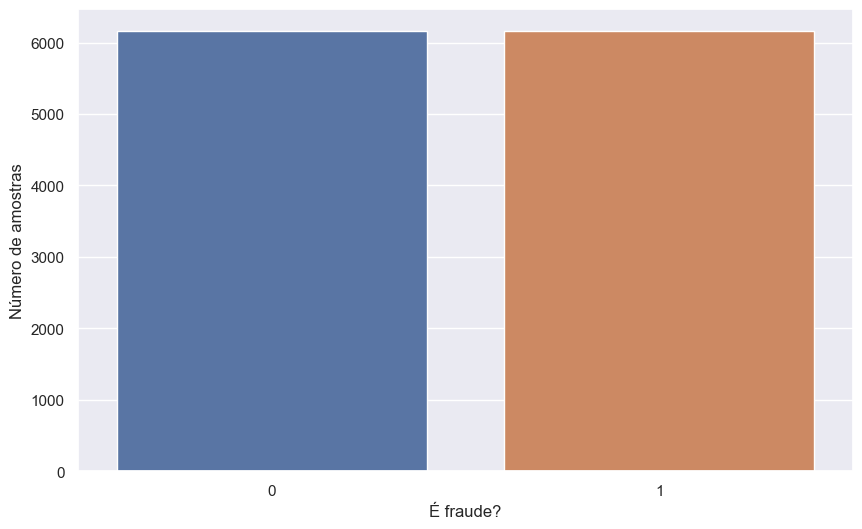

In [23]:
# usar técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# plotar a nova distribuição de classes
fig, ax = plt.subplots(figsize=(10,6), sharex=True)

sns.countplot(y_rus);

ax.set_xlabel('É fraude?')
ax.set_ylabel('Número de amostras')

Com os dados balanceados, podemos ver a matriz de correlação e identificar quais variáveis estão mais fortemente relacionadas com as outras.

Observe como anteriormente, sem o balanceamento de dados, a matriz de correlação não trazia muita informação relevante. Entretanto, ela traz muito mais informações após um correto balanceamento.

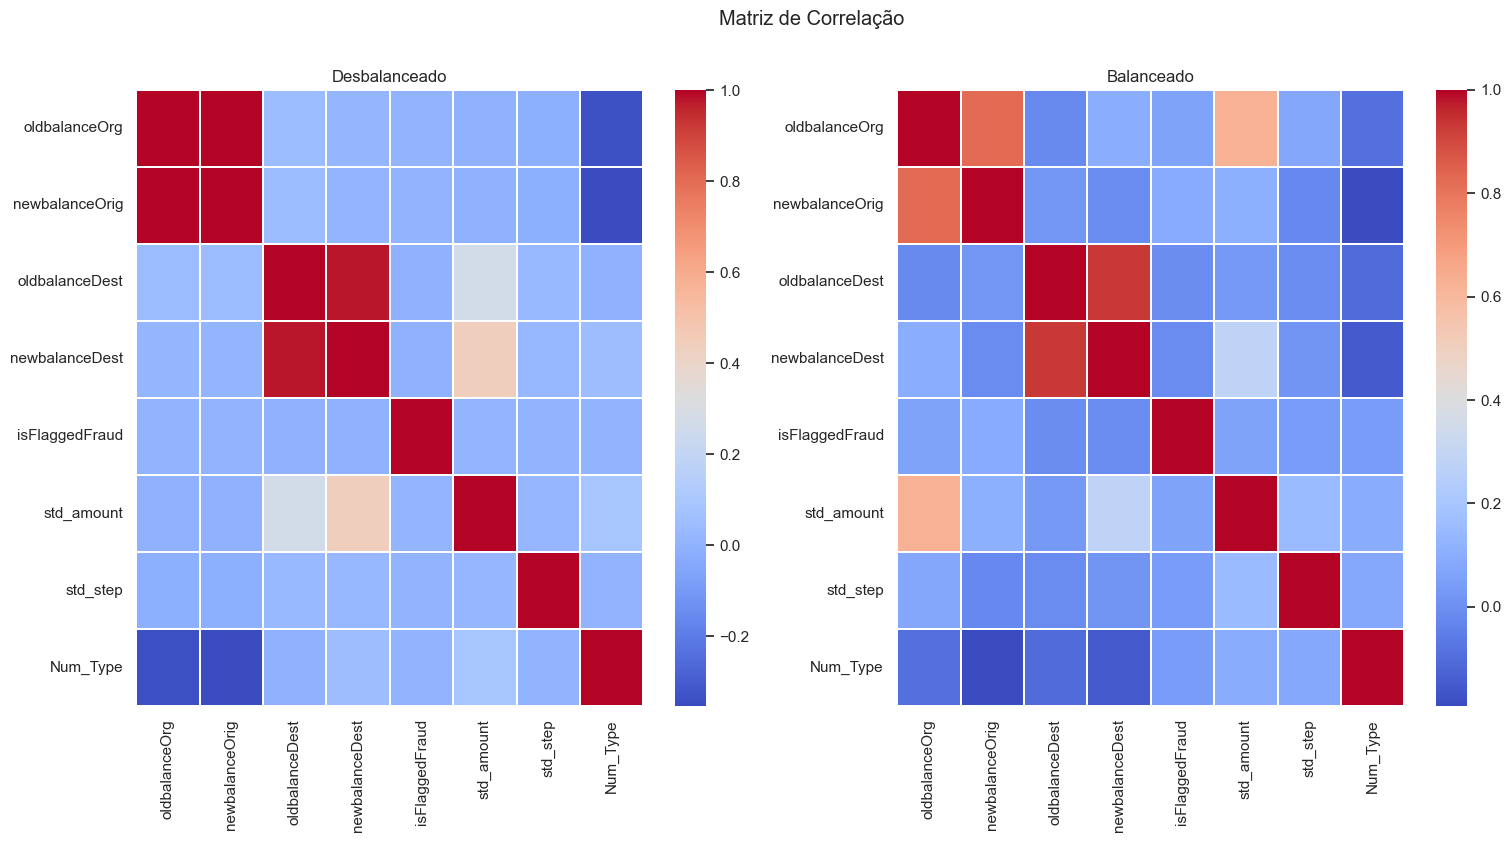

In [24]:
# plotar a matriz de correlação
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])

ax[0].set_title('Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])

ax[1].set_title('Balanceado')

plt.show()

###Modelo de Machine Learning

Com todos os dados pré-processados e após a análise exploratória completa, irei construir o classificador usando a Regressão Logística.

O mesmo será treinado em cima dos dados X_rus e y_rus. Na sequência, serão realizadas previsões sobre os dados de teste.

In [25]:
# instanciar e treinar um modelo de Regressão Logística
np.random.seed(2)
model = LogisticRegression()
model.fit(X_rus, y_rus)

# fazer as previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Com o modelo treinado e as previsões feitas, parte-se para a avaliação do desempenho.

É possível observar a matriz de confusão para ver a taxa de acertos para transações fraudulentas, ou pela coluna recall do Relatório de Classificação.

Uma outra métrica considerada interessante para se avaliar a eficácia é a AUC ROC, ou área sob a curva. No caso desse modelo de Regressão Logística, tem-se 95% de AUC

Relatório de Classificação:
               precision    recall  f1-score   support

           0     1.0000    0.9408    0.9695   1588602
           1     0.0210    0.9805    0.0411      2053

    accuracy                         0.9409   1590655
   macro avg     0.5105    0.9607    0.5053   1590655
weighted avg     0.9987    0.9409    0.9683   1590655

Acurácia: 0.9409

AUC: 0.9860



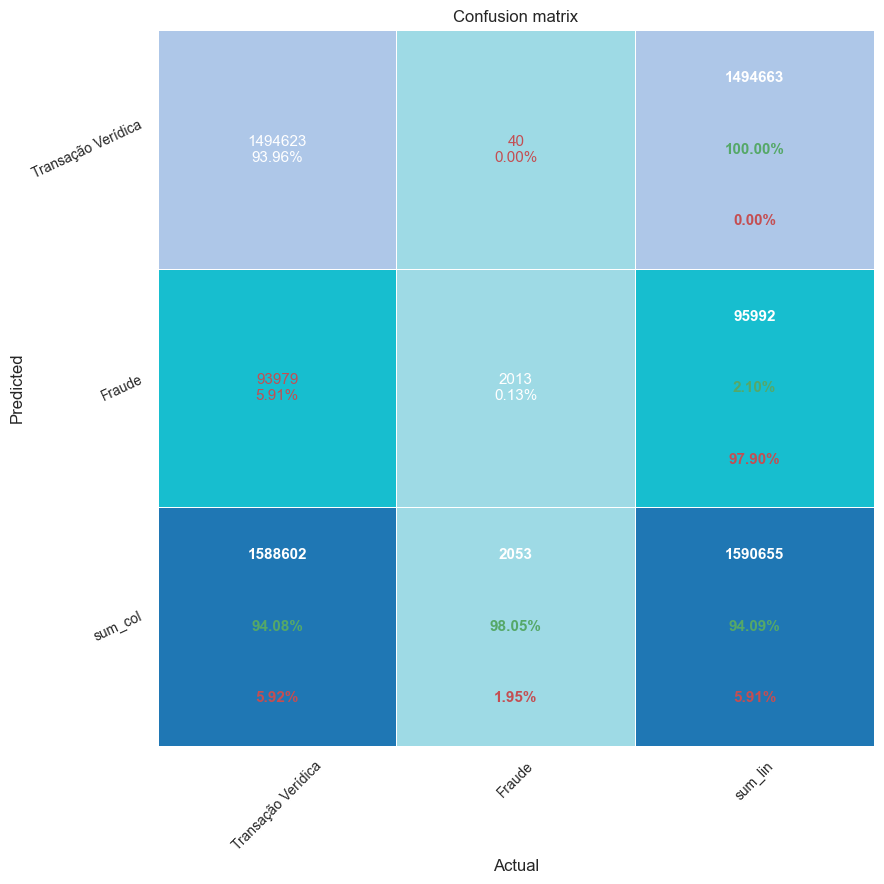

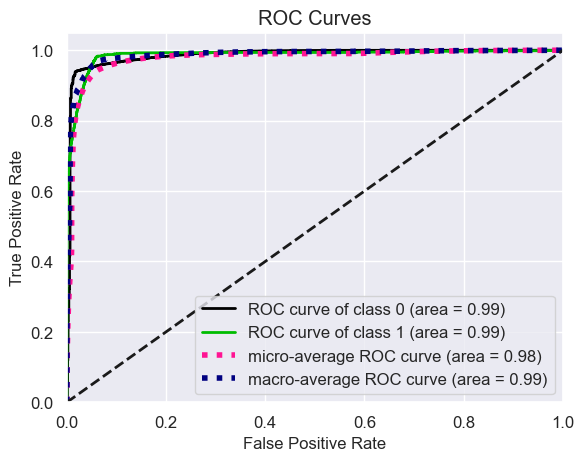

In [26]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# imprimir o valor da métrica área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_proba[:,1])))

# plotar a matrix de confusão
from pretty_confusion_matrix import pp_matrix_from_data

colunas = ['Transação Verídica', 'Fraude']
pp_matrix_from_data(y_test, y_pred, cmap='tab20_r', columns=colunas)

#imprimir o gráfico de AUC
skplt.metrics.plot_roc_curve(y_test, y_proba)
plt.show()

##Conclusões

Como você pode observar, não se trata de um problema trivial. Apesar dos dados estarem ravoavelmente tratados, tinhamos variáveis ausentes no caso dos clientes destinatários, desvio padrão muito alto nos valores das transações e também variáveis categóricas para o tipo de transação. Além disso, o desbalanceamento demandou um trabalho considerável.

Obviamente, apesar do bom resultado final, há espaço para testar o desempenho com outros algoritmos de classificação, além de otimizar seus parâmetros.